In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
df1 = pd.read_pickle('E:/base.pkl')
df1['k1'] = 1.2
df1['c'] = 60
df1.drop('doc', axis=1, inplace=True)

In [4]:
df2 = pd.read_pickle('E:/fulltext.pkl')

In [5]:
df = pd.concat([df1, df2])

In [6]:
df.mean_relevance = df['relevance'].apply(lambda x: sum(x)/len(x))

In [ ]:
# df['dataset_label'] = df.dataset.apply(lambda x: int(x=='bench'))

In [ ]:
# from ydata_profiling import ProfileReport
# df_prof = df.drop(['texts', 'rel_sent', 'relevance', 'response', 'LOFs', 'llm_answer', ], axis=1)

# def make_good_name(name:str) -> str:
#     if '.mirage_index' in name:
#         if 'indexes2' in name:
#             return name[name.index('_')+1:-16]
#         else:
#             return name.split('/')[-1][:-16]
#     else:
#         return name
    
# df_prof.question_id = df_prof.question_id.astype(int)
# df_prof.k1 = df_prof.k1.astype(float)
# df_prof.c = df_prof.c.astype(int)

# df_prof.file = df_prof.file.apply(make_good_name)

# df_prof[['chunk_strategy', 'chunk_len', 'stride', 'embedder']] = df_prof.file.str.split('_', expand=True)

# df_prof.chunk_len = df_prof.chunk_len.astype(int)
# df_prof.stride = df_prof.stride.astype(float)

# df_prof.embedder = df_prof.embedder.apply(lambda x: ['BAAI', 'intfloat', 'DeepPavlov', 'thenlper'].index(x))
# df_prof.chunk_strategy = df_prof.chunk_strategy.apply(lambda x: ['S', 'W'].index(x))

# profile = ProfileReport(df_prof, title="YData Profiling Report")

# profile.to_file("your_report.html")

Summarize dataset:  85%|████████▍ | 28/33 [00:00<00:00, 31.91it/s, Calculate auto correlation] c:\Python312\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
c:\Python312\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 9 9 ... 1 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
c:\Python312\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in

In [9]:
df = df.drop([
    # 'file',
 'texts',
 'rel_sent',
 'relevance',
 'question',
 'response',
 'LOFs',
 'llm_answer',
 'dataset',
 'completeness',
 'cc',
 'question_id',
 'cr',
 'generation_seconds_check',
 'generation_seconds',
 'mean_relevance'], axis=1)

In [7]:
def make_good_name(name:str) -> str:
    if '.mirage_index' in name:
        if 'indexes2' in name:
            return name[name.index('_')+1:-16]
        else:
            return name.split('/')[-1][:-16]
    else:
        return name

df.file = df.file.apply(make_good_name)

In [8]:
# df.question_id = df.question_id.astype(int)
df.k1 = df.k1.astype(float)
df.c = df.c.astype(int)

In [9]:
df[['chunk_strategy', 'chunk_len', 'stride', 'embedder']] = df.file.str.split('_', expand=True)

In [10]:
df.chunk_len = df.chunk_len.astype(int)
df.stride = df.stride.astype(float)

# df.embedder = df.embedder.apply(lambda x: ['BAAI', 'intfloat', 'DeepPavlov', 'thenlper'].index(x))
# df.chunk_strategy = df.chunk_strategy.apply(lambda x: ['S', 'W'].index(x))

In [14]:
def calac_acc(file, c, k1):
    t = df[(df.file == file) & (df.c == c) & (df.k1 == k1)]
    return t.correctness.mean()

calac_acc('S_16_0.1_BAAI', 60, 1.2)

0.55625

In [15]:
extra_df = df.drop_duplicates()
extra_df['mean'] = extra_df.progress_apply(lambda x: calac_acc(x['file'], x['c'], x['k1']), axis=1)

100%|██████████| 960/960 [00:01<00:00, 482.47it/s]
C:\Users\evgen\AppData\Local\Temp\ipykernel_16196\2606166329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_df['mean'] = extra_df.progress_apply(lambda x: calac_acc(x['file'], x['c'], x['k1']), axis=1)


0:	learn: 0.6012610	test: 0.6168939	best: 0.6168939 (0)	total: 135ms	remaining: 1m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6168939142
bestIteration = 0

Shrink model to first 1 iterations.

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      4119
           1       0.76      0.52      0.62      3561

    accuracy                           0.70      7680
   macro avg       0.71      0.69      0.69      7680
weighted avg       0.71      0.70      0.69      7680



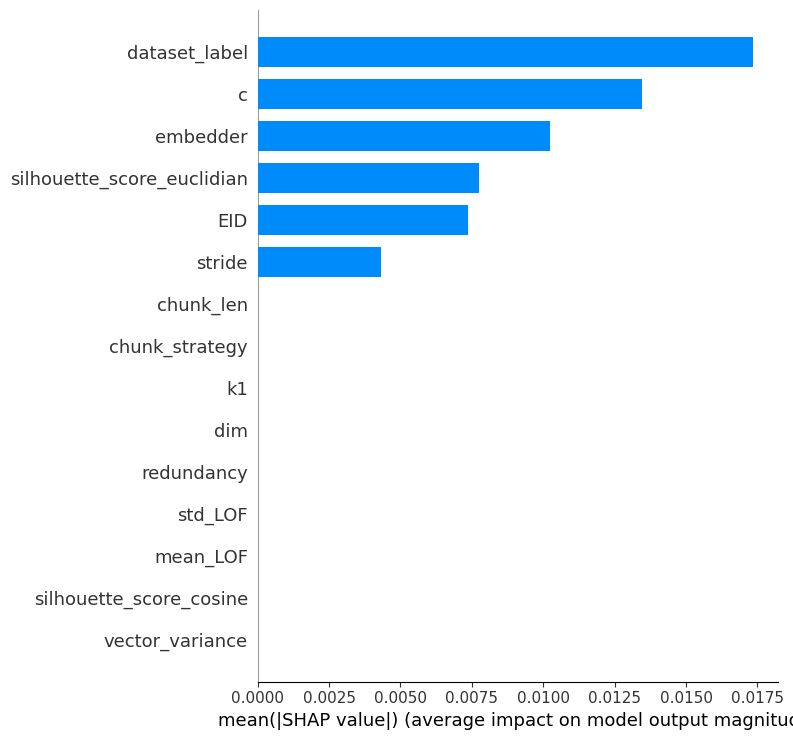

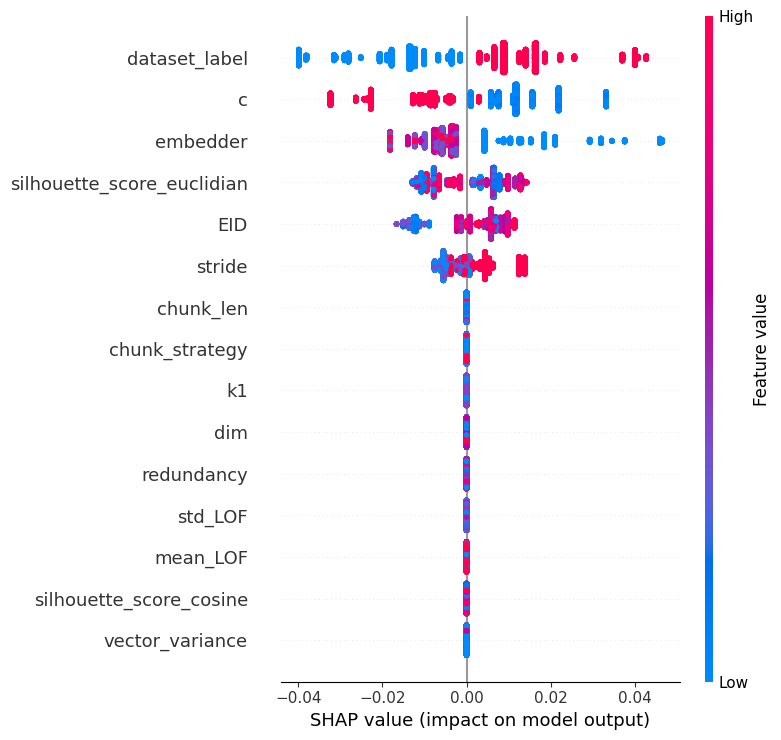

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import classification_report

# Assuming your dataframe is called 'df' with target 'correctness'
# Split into features and target
X = df.drop(['correctness', 'file'], axis=1)
y = df['correctness']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize CatBoost classifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    random_seed=42,
    verbose=100  # prints progress every 100 iterations
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=20,
    use_best_model=True
)

# Evaluate on test set
y_pred = model.predict(X_test)
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# For more detailed analysis of specific features:
# shap.dependence_plot("feature_name", shap_values, X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.4999903	total: 10.5ms	remaining: 0us
Test R-squared: -0.0461


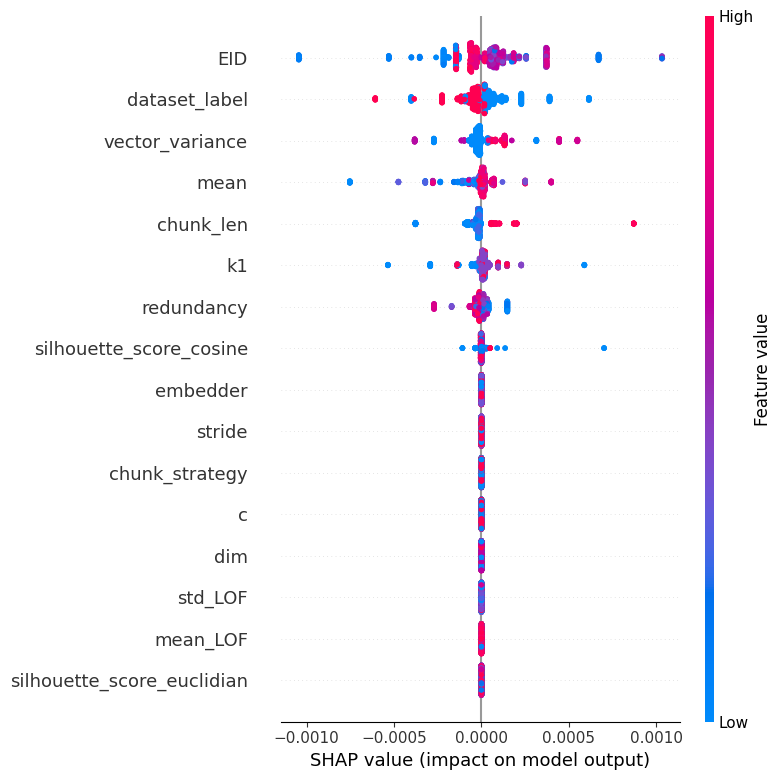

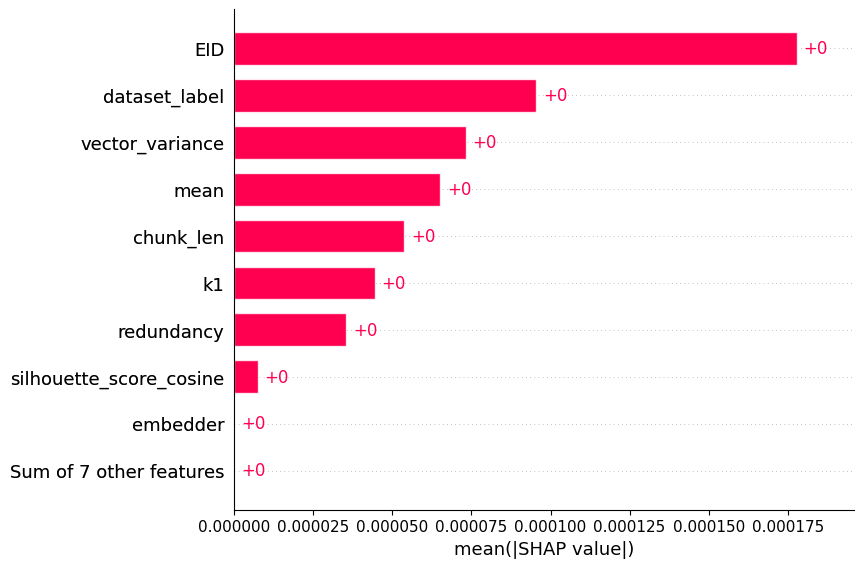

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import shap

# Assuming extra_df is your pandas DataFrame
# Separate features and target
X = extra_df.drop(columns=['correctness', 'file'])  # Features
y = extra_df['correctness']  # Target (0 to 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=42
)

# Initialize CatBoost regressor
model = CatBoostRegressor(
    iterations=1,
    learning_rate=0.1,
    depth=10,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,  # Prints progress every 100 iterations,
    penalties_coefficient=10
)

# Fit the model
model.fit(
    # X_train, y_train,
    X_train, y_train,
    # eval_set=(X_test, y_test),
    use_best_model=True,
    plot=True
)

# Evaluate on test set
test_score = model.score(X_test, y_test)
print(f"Test R-squared: {test_score:.4f}")

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot summary plot
shap.summary_plot(shap_values, X)

# Plot feature importance
shap.plots.bar(shap_values)

In [19]:
extra_df

,file,vector_variance,silhouette_score_euclidian,silhouette_score_cosine,mean_LOF,std_LOF,correctness,EID,redundancy,dim,k1,c,dataset_label,chunk_strategy,chunk_len,stride,embedder,mean
0,S_16_0.1_BAAI,0.404626,0.094661,0.168449,0.996198,0.087121,1,206.007952,0.798820,1024,1.2,60,1,0,16,0.1,0,0.55625
2,S_16_0.1_BAAI,0.404626,0.094661,0.168449,0.996198,0.087121,0,206.007952,0.798820,1024,1.2,60,1,0,16,0.1,0,0.55625
80,S_16_0.1_DeepPavlov,68.276460,0.126166,0.198874,0.969582,0.244768,1,51.182835,0.933356,768,1.2,60,1,0,16,0.1,2,0.40625
81,S_16_0.1_DeepPavlov,68.276460,0.126166,0.198874,0.969582,0.244768,0,51.182835,0.933356,768,1.2,60,1,0,16,0.1,2,0.40625
160,S_16_0.1_intfloat,0.081222,0.011460,0.017142,0.996190,0.087204,0,160.274212,0.582619,384,1.2,60,1,0,16,0.1,1,0.27500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18962,W_256_0.1_intfloat,0.173436,0.121403,0.213495,0.998187,0.060193,0,226.587097,0.409929,384,1.0,8,0,1,256,0.1,1,0.56250
19040,W_256_0.1_intfloat,0.173436,0.121403,0.213495,0.998187,0.060193,0,226.587097,0.409929,384,1.2,8,0,1,256,0.1,1,0.50625
19041,W_256_0.1_intfloat,0.173436,0.121403,0.213495,0.998187,0.060193,1,226.587097,0.409929,384,1.2,8,0,1,256,0.1,1,0.50625
19120,W_256_0.1_intfloat,0.173436,0.121403,0.213495,0.998187,0.060193,0,226.587097,0.409929,384,1.5,8,0,1,256,0.1,1,0.53750
